# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [98]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

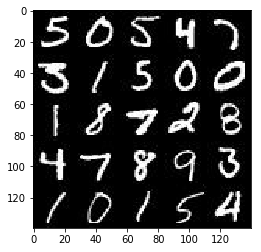

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

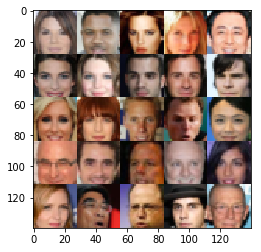

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [118]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                              padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                              padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                              padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [119]:
def generator(z, out_channel_dim=3, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1,7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), 
                                        padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), 
                                        padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, 
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                                            padding='same')
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [120]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.9
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [121]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [122]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [123]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_images=25
    
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, image_channels, alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    step=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step+=1
                # TODO: Train Model
                batch_images=batch_images*2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input:batch_images, z_input:batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input:batch_images, z_input:batch_z, lr: learning_rate})
                
                if step % print_every == 0:
                    train_d_loss = d_loss.eval({real_input:batch_images, z_input:batch_z})
                    train_g_loss = g_loss.eval({z_input:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                        "Discriminator Loss: {:.4f}".format(train_d_loss),
                        "Generator Loss: {:.4f}".format(train_g_loss))
                
                if step % show_every == 0:
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)
                       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1608 Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 1.0437 Generator Loss: 1.6333
Epoch 1/2... Discriminator Loss: 0.9562 Generator Loss: 2.2524
Epoch 1/2... Discriminator Loss: 1.0704 Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 0.9818 Generator Loss: 1.2368
Epoch 1/2... Discriminator Loss: 1.2779 Generator Loss: 0.5999
Epoch 1/2... Discriminator Loss: 1.2786 Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.3335 Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.2851 Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.2056 Generator Loss: 0.8247


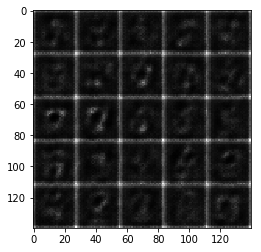

Epoch 1/2... Discriminator Loss: 1.3666 Generator Loss: 0.5519
Epoch 1/2... Discriminator Loss: 1.2141 Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.3087 Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.2298 Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.0715 Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.2689 Generator Loss: 2.0728
Epoch 1/2... Discriminator Loss: 1.0770 Generator Loss: 1.1233
Epoch 1/2... Discriminator Loss: 1.0120 Generator Loss: 1.5105
Epoch 1/2... Discriminator Loss: 0.9854 Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.0858 Generator Loss: 1.0700


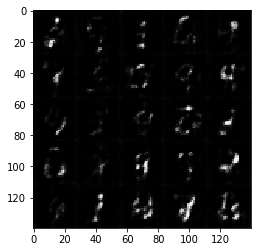

Epoch 1/2... Discriminator Loss: 1.4895 Generator Loss: 0.4429
Epoch 1/2... Discriminator Loss: 0.9776 Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 0.9590 Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 0.8660 Generator Loss: 1.7246
Epoch 1/2... Discriminator Loss: 0.9179 Generator Loss: 1.6491
Epoch 1/2... Discriminator Loss: 0.7975 Generator Loss: 1.6150
Epoch 1/2... Discriminator Loss: 0.8453 Generator Loss: 1.9237
Epoch 1/2... Discriminator Loss: 1.0547 Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 0.9326 Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 0.7533 Generator Loss: 1.6697


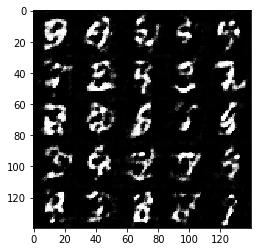

Epoch 1/2... Discriminator Loss: 0.9443 Generator Loss: 0.9834
Epoch 1/2... Discriminator Loss: 0.8768 Generator Loss: 1.1131
Epoch 1/2... Discriminator Loss: 0.7464 Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 0.8649 Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 0.9966 Generator Loss: 0.9509
Epoch 1/2... Discriminator Loss: 0.7726 Generator Loss: 1.3137
Epoch 1/2... Discriminator Loss: 1.2285 Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 0.7658 Generator Loss: 2.1190
Epoch 1/2... Discriminator Loss: 0.9114 Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 0.8942 Generator Loss: 1.2716


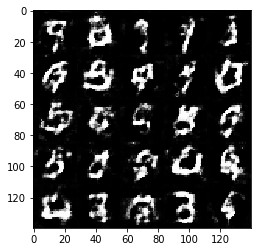

Epoch 1/2... Discriminator Loss: 0.8806 Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 0.8728 Generator Loss: 1.3448
Epoch 1/2... Discriminator Loss: 1.0777 Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 1.0338 Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 1.3880 Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.0290 Generator Loss: 1.1271
Epoch 1/2... Discriminator Loss: 1.0982 Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 0.9293 Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 1.1049 Generator Loss: 1.1870
Epoch 1/2... Discriminator Loss: 1.5117 Generator Loss: 0.4803


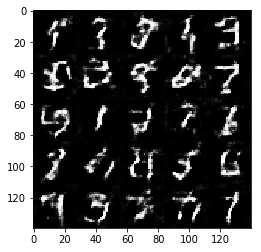

Epoch 1/2... Discriminator Loss: 0.8804 Generator Loss: 1.1178
Epoch 1/2... Discriminator Loss: 1.0254 Generator Loss: 1.0652
Epoch 1/2... Discriminator Loss: 1.0762 Generator Loss: 1.1092
Epoch 1/2... Discriminator Loss: 0.8640 Generator Loss: 1.3352
Epoch 1/2... Discriminator Loss: 1.0037 Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 0.9367 Generator Loss: 1.0964
Epoch 1/2... Discriminator Loss: 1.0231 Generator Loss: 1.1519
Epoch 1/2... Discriminator Loss: 0.8913 Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 0.9306 Generator Loss: 1.3921
Epoch 1/2... Discriminator Loss: 0.9831 Generator Loss: 1.4905


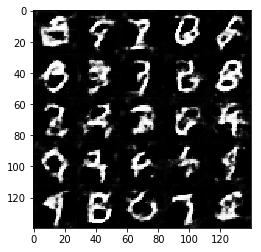

Epoch 1/2... Discriminator Loss: 1.1751 Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.0232 Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 0.9081 Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 0.9008 Generator Loss: 1.3617
Epoch 1/2... Discriminator Loss: 0.8506 Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 0.9776 Generator Loss: 1.6900
Epoch 1/2... Discriminator Loss: 1.2641 Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 1.0717 Generator Loss: 0.7975
Epoch 1/2... Discriminator Loss: 1.1321 Generator Loss: 1.6218
Epoch 1/2... Discriminator Loss: 0.9278 Generator Loss: 1.0302


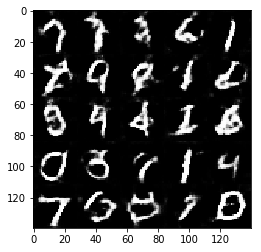

Epoch 1/2... Discriminator Loss: 0.9564 Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 0.9065 Generator Loss: 1.2355
Epoch 1/2... Discriminator Loss: 0.9506 Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 0.9765 Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 1.0190 Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 0.8751 Generator Loss: 1.1831
Epoch 1/2... Discriminator Loss: 1.0122 Generator Loss: 1.6947
Epoch 1/2... Discriminator Loss: 1.2506 Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 0.9070 Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 1.0494 Generator Loss: 0.8783


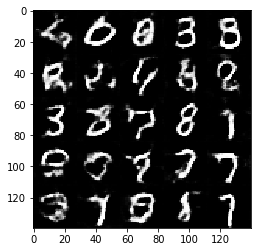

Epoch 1/2... Discriminator Loss: 1.2037 Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.3030 Generator Loss: 2.0691
Epoch 1/2... Discriminator Loss: 1.3158 Generator Loss: 0.5818
Epoch 1/2... Discriminator Loss: 1.0919 Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.0946 Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 0.8123 Generator Loss: 1.2139
Epoch 1/2... Discriminator Loss: 1.0599 Generator Loss: 1.2118
Epoch 1/2... Discriminator Loss: 0.8511 Generator Loss: 1.3895
Epoch 1/2... Discriminator Loss: 1.0755 Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 0.9068 Generator Loss: 1.0718


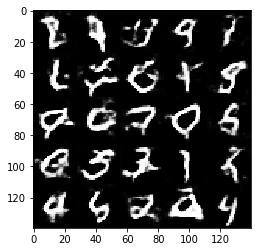

Epoch 1/2... Discriminator Loss: 0.9340 Generator Loss: 1.0426
Epoch 1/2... Discriminator Loss: 0.8844 Generator Loss: 1.2782
Epoch 1/2... Discriminator Loss: 1.0341 Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 0.9073 Generator Loss: 1.0880
Epoch 1/2... Discriminator Loss: 1.0097 Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 0.7974 Generator Loss: 1.5903
Epoch 1/2... Discriminator Loss: 0.9845 Generator Loss: 1.8397
Epoch 1/2... Discriminator Loss: 0.9837 Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 0.9015 Generator Loss: 1.0916
Epoch 1/2... Discriminator Loss: 1.0102 Generator Loss: 1.3528


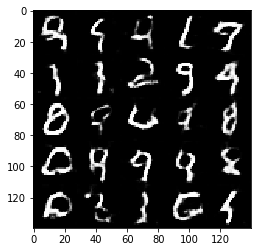

Epoch 1/2... Discriminator Loss: 0.9716 Generator Loss: 1.1472
Epoch 1/2... Discriminator Loss: 1.0888 Generator Loss: 1.8716
Epoch 1/2... Discriminator Loss: 0.8963 Generator Loss: 1.7049
Epoch 1/2... Discriminator Loss: 1.0173 Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 0.8704 Generator Loss: 1.3440
Epoch 1/2... Discriminator Loss: 0.8779 Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.8640 Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 1.0676 Generator Loss: 0.8476
Epoch 1/2... Discriminator Loss: 0.8860 Generator Loss: 1.0547
Epoch 1/2... Discriminator Loss: 0.8511 Generator Loss: 1.9277


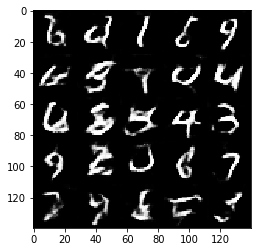

Epoch 1/2... Discriminator Loss: 1.0601 Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.0165 Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.0257 Generator Loss: 0.9464
Epoch 1/2... Discriminator Loss: 0.8894 Generator Loss: 1.1376
Epoch 1/2... Discriminator Loss: 0.8452 Generator Loss: 1.3087
Epoch 1/2... Discriminator Loss: 0.8260 Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 1.1861 Generator Loss: 0.6620
Epoch 1/2... Discriminator Loss: 1.4899 Generator Loss: 0.4500
Epoch 1/2... Discriminator Loss: 0.8391 Generator Loss: 1.1161
Epoch 1/2... Discriminator Loss: 1.2105 Generator Loss: 0.6378


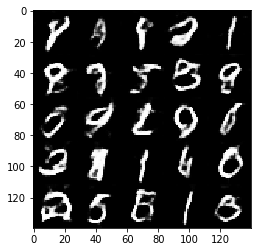

Epoch 1/2... Discriminator Loss: 0.8552 Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 0.9265 Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.0318 Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 0.9760 Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.0642 Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 0.9461 Generator Loss: 0.9450
Epoch 1/2... Discriminator Loss: 0.8709 Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.7880 Generator Loss: 1.2511
Epoch 1/2... Discriminator Loss: 0.8886 Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 0.8774 Generator Loss: 1.0553


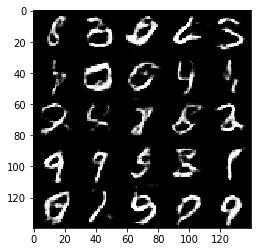

Epoch 1/2... Discriminator Loss: 1.0562 Generator Loss: 1.8890
Epoch 1/2... Discriminator Loss: 0.8498 Generator Loss: 1.1953
Epoch 1/2... Discriminator Loss: 1.0362 Generator Loss: 0.7875
Epoch 1/2... Discriminator Loss: 1.1947 Generator Loss: 1.7840
Epoch 1/2... Discriminator Loss: 0.8991 Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 1.1908 Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.0187 Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 1.0558 Generator Loss: 1.5018
Epoch 1/2... Discriminator Loss: 0.9727 Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 0.9990 Generator Loss: 0.9852


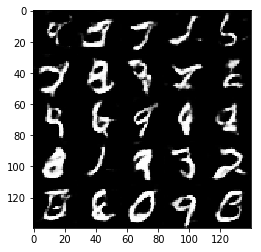

Epoch 1/2... Discriminator Loss: 0.9167 Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 0.7827 Generator Loss: 1.2430
Epoch 1/2... Discriminator Loss: 1.1711 Generator Loss: 1.5986
Epoch 1/2... Discriminator Loss: 0.9188 Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 1.0048 Generator Loss: 0.9436
Epoch 1/2... Discriminator Loss: 1.2748 Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 0.8270 Generator Loss: 2.2226
Epoch 1/2... Discriminator Loss: 0.8562 Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 1.0093 Generator Loss: 0.8180
Epoch 1/2... Discriminator Loss: 1.2978 Generator Loss: 0.5525


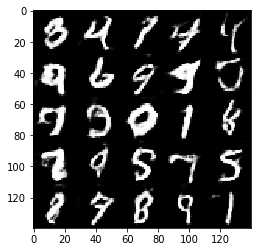

Epoch 1/2... Discriminator Loss: 0.8953 Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 0.6557 Generator Loss: 1.7806
Epoch 1/2... Discriminator Loss: 1.2268 Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 0.7955 Generator Loss: 1.2561
Epoch 1/2... Discriminator Loss: 0.7387 Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 0.8029 Generator Loss: 1.2482
Epoch 1/2... Discriminator Loss: 2.1924 Generator Loss: 4.4991
Epoch 1/2... Discriminator Loss: 0.8548 Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 0.9750 Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 0.8435 Generator Loss: 1.5936


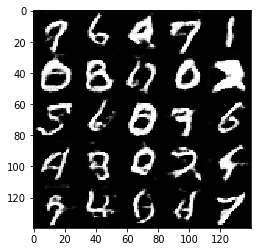

Epoch 1/2... Discriminator Loss: 0.8803 Generator Loss: 1.7042
Epoch 1/2... Discriminator Loss: 0.9174 Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 1.0628 Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 0.8186 Generator Loss: 1.1754
Epoch 1/2... Discriminator Loss: 2.0539 Generator Loss: 3.5648
Epoch 1/2... Discriminator Loss: 1.0715 Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 0.8641 Generator Loss: 1.1558
Epoch 1/2... Discriminator Loss: 0.9281 Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 2.0530 Generator Loss: 3.4485
Epoch 1/2... Discriminator Loss: 0.8742 Generator Loss: 1.2712


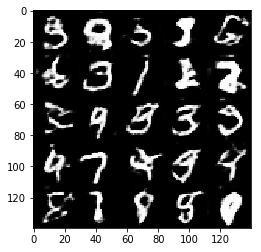

Epoch 1/2... Discriminator Loss: 0.8377 Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 1.6080 Generator Loss: 0.4176
Epoch 1/2... Discriminator Loss: 0.8813 Generator Loss: 1.0804
Epoch 1/2... Discriminator Loss: 0.8106 Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 0.9244 Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 0.8938 Generator Loss: 1.4487
Epoch 1/2... Discriminator Loss: 0.8253 Generator Loss: 1.2561
Epoch 1/2... Discriminator Loss: 0.9178 Generator Loss: 1.8738
Epoch 1/2... Discriminator Loss: 1.1040 Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 0.8536 Generator Loss: 1.2058


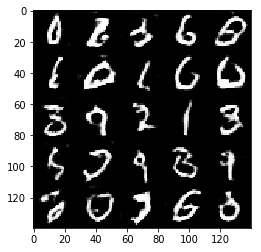

Epoch 1/2... Discriminator Loss: 0.8122 Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 0.9230 Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 0.7700 Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 0.8700 Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 0.8731 Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 0.8120 Generator Loss: 1.1346
Epoch 1/2... Discriminator Loss: 0.8112 Generator Loss: 1.2418
Epoch 2/2... Discriminator Loss: 0.9155 Generator Loss: 0.9702
Epoch 2/2... Discriminator Loss: 1.1293 Generator Loss: 2.4283
Epoch 2/2... Discriminator Loss: 0.9448 Generator Loss: 1.4043


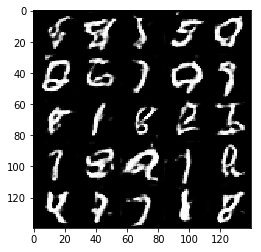

Epoch 2/2... Discriminator Loss: 1.0319 Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 0.8722 Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 0.8785 Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 0.8896 Generator Loss: 1.0725
Epoch 2/2... Discriminator Loss: 1.5787 Generator Loss: 0.4641
Epoch 2/2... Discriminator Loss: 1.3337 Generator Loss: 0.5727
Epoch 2/2... Discriminator Loss: 0.7585 Generator Loss: 1.3120
Epoch 2/2... Discriminator Loss: 0.7486 Generator Loss: 1.5603
Epoch 2/2... Discriminator Loss: 0.8236 Generator Loss: 1.6827
Epoch 2/2... Discriminator Loss: 0.9566 Generator Loss: 0.8955


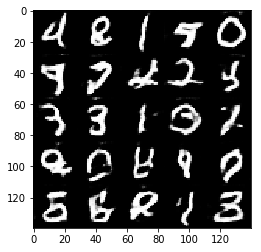

Epoch 2/2... Discriminator Loss: 1.1669 Generator Loss: 3.0487
Epoch 2/2... Discriminator Loss: 1.0371 Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 0.7581 Generator Loss: 1.3106
Epoch 2/2... Discriminator Loss: 0.9423 Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 0.7486 Generator Loss: 1.6447
Epoch 2/2... Discriminator Loss: 0.8039 Generator Loss: 1.2403
Epoch 2/2... Discriminator Loss: 0.8239 Generator Loss: 1.3088
Epoch 2/2... Discriminator Loss: 0.6465 Generator Loss: 1.6059
Epoch 2/2... Discriminator Loss: 0.7166 Generator Loss: 1.5014
Epoch 2/2... Discriminator Loss: 0.7711 Generator Loss: 1.6239


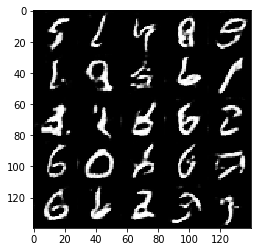

Epoch 2/2... Discriminator Loss: 0.8629 Generator Loss: 1.9045
Epoch 2/2... Discriminator Loss: 1.1043 Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 1.1721 Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.2376 Generator Loss: 2.5320
Epoch 2/2... Discriminator Loss: 0.8610 Generator Loss: 1.2366
Epoch 2/2... Discriminator Loss: 0.8664 Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 0.8578 Generator Loss: 1.1855
Epoch 2/2... Discriminator Loss: 0.6278 Generator Loss: 1.6532
Epoch 2/2... Discriminator Loss: 0.8902 Generator Loss: 1.3757
Epoch 2/2... Discriminator Loss: 0.9405 Generator Loss: 0.9901


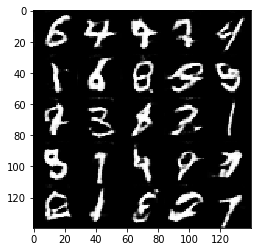

Epoch 2/2... Discriminator Loss: 0.8886 Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 0.9577 Generator Loss: 1.6272
Epoch 2/2... Discriminator Loss: 0.8145 Generator Loss: 1.1693
Epoch 2/2... Discriminator Loss: 0.8039 Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 0.8254 Generator Loss: 1.3411
Epoch 2/2... Discriminator Loss: 1.2425 Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 0.8161 Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 0.9933 Generator Loss: 1.1408
Epoch 2/2... Discriminator Loss: 0.8954 Generator Loss: 1.1583
Epoch 2/2... Discriminator Loss: 1.0550 Generator Loss: 0.8535


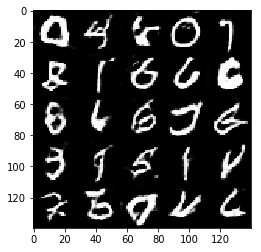

Epoch 2/2... Discriminator Loss: 2.3687 Generator Loss: 0.2389
Epoch 2/2... Discriminator Loss: 1.7272 Generator Loss: 0.3485
Epoch 2/2... Discriminator Loss: 0.8697 Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 0.7625 Generator Loss: 1.4238
Epoch 2/2... Discriminator Loss: 0.6766 Generator Loss: 1.7292
Epoch 2/2... Discriminator Loss: 0.6750 Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 1.0358 Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 0.6401 Generator Loss: 1.5619
Epoch 2/2... Discriminator Loss: 0.6184 Generator Loss: 1.6264
Epoch 2/2... Discriminator Loss: 0.7202 Generator Loss: 1.2792


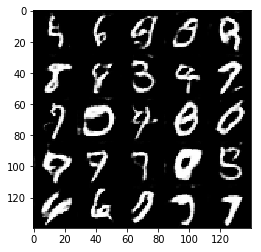

Epoch 2/2... Discriminator Loss: 1.0366 Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 0.7729 Generator Loss: 1.3620
Epoch 2/2... Discriminator Loss: 1.2897 Generator Loss: 0.6006
Epoch 2/2... Discriminator Loss: 0.8227 Generator Loss: 1.9067
Epoch 2/2... Discriminator Loss: 0.8920 Generator Loss: 1.0256
Epoch 2/2... Discriminator Loss: 0.9676 Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 0.6956 Generator Loss: 1.8525
Epoch 2/2... Discriminator Loss: 0.7265 Generator Loss: 1.4477
Epoch 2/2... Discriminator Loss: 0.9213 Generator Loss: 1.9792
Epoch 2/2... Discriminator Loss: 0.8795 Generator Loss: 1.7618


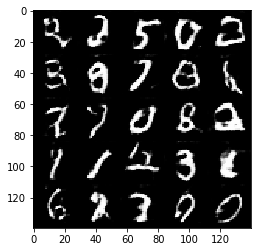

Epoch 2/2... Discriminator Loss: 0.6876 Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 0.7325 Generator Loss: 1.3009
Epoch 2/2... Discriminator Loss: 0.8067 Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 1.1570 Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.8563 Generator Loss: 2.1348
Epoch 2/2... Discriminator Loss: 1.1830 Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 0.7813 Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 0.8851 Generator Loss: 1.1406
Epoch 2/2... Discriminator Loss: 0.8127 Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 0.5940 Generator Loss: 1.8654


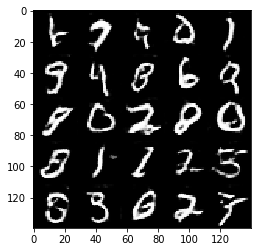

Epoch 2/2... Discriminator Loss: 1.0102 Generator Loss: 2.6301
Epoch 2/2... Discriminator Loss: 1.2426 Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 0.7222 Generator Loss: 1.3661
Epoch 2/2... Discriminator Loss: 0.7148 Generator Loss: 1.4374
Epoch 2/2... Discriminator Loss: 1.1620 Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 0.7377 Generator Loss: 1.4585
Epoch 2/2... Discriminator Loss: 0.7778 Generator Loss: 1.2416
Epoch 2/2... Discriminator Loss: 0.6800 Generator Loss: 1.3932
Epoch 2/2... Discriminator Loss: 0.6789 Generator Loss: 1.6517
Epoch 2/2... Discriminator Loss: 0.7284 Generator Loss: 1.3336


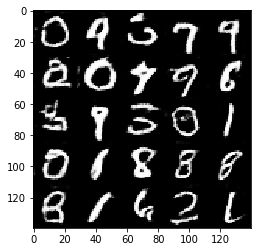

Epoch 2/2... Discriminator Loss: 0.6976 Generator Loss: 1.5740
Epoch 2/2... Discriminator Loss: 0.7643 Generator Loss: 1.6196
Epoch 2/2... Discriminator Loss: 1.1721 Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 0.8428 Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.8289 Generator Loss: 1.5908
Epoch 2/2... Discriminator Loss: 0.7359 Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 0.6329 Generator Loss: 1.5163
Epoch 2/2... Discriminator Loss: 0.9254 Generator Loss: 0.9736
Epoch 2/2... Discriminator Loss: 0.7413 Generator Loss: 1.9386
Epoch 2/2... Discriminator Loss: 1.1752 Generator Loss: 0.8183


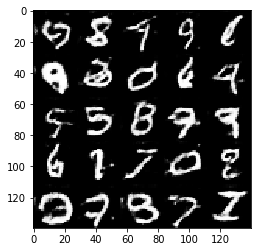

Epoch 2/2... Discriminator Loss: 0.6750 Generator Loss: 1.7274
Epoch 2/2... Discriminator Loss: 0.8433 Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 0.7858 Generator Loss: 2.0822
Epoch 2/2... Discriminator Loss: 0.9282 Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 0.6670 Generator Loss: 1.5499
Epoch 2/2... Discriminator Loss: 0.6926 Generator Loss: 1.3984
Epoch 2/2... Discriminator Loss: 0.8833 Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 0.8877 Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 0.7514 Generator Loss: 1.3383
Epoch 2/2... Discriminator Loss: 0.8251 Generator Loss: 1.1522


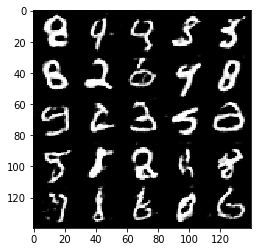

Epoch 2/2... Discriminator Loss: 1.3988 Generator Loss: 0.5556
Epoch 2/2... Discriminator Loss: 0.7920 Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 0.7717 Generator Loss: 1.6749
Epoch 2/2... Discriminator Loss: 0.8209 Generator Loss: 1.1465
Epoch 2/2... Discriminator Loss: 0.7886 Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 0.7918 Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 0.7852 Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 0.7953 Generator Loss: 2.6379
Epoch 2/2... Discriminator Loss: 0.6607 Generator Loss: 1.8275
Epoch 2/2... Discriminator Loss: 0.7546 Generator Loss: 1.2942


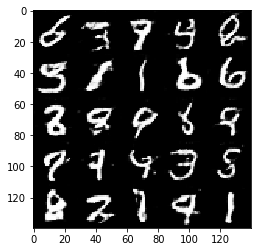

Epoch 2/2... Discriminator Loss: 0.6272 Generator Loss: 2.0285
Epoch 2/2... Discriminator Loss: 0.7510 Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 0.6836 Generator Loss: 1.4794
Epoch 2/2... Discriminator Loss: 0.6867 Generator Loss: 1.5641
Epoch 2/2... Discriminator Loss: 1.1725 Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 0.8336 Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 0.7081 Generator Loss: 1.3887
Epoch 2/2... Discriminator Loss: 0.6904 Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 0.8176 Generator Loss: 1.2187
Epoch 2/2... Discriminator Loss: 0.6128 Generator Loss: 1.6284


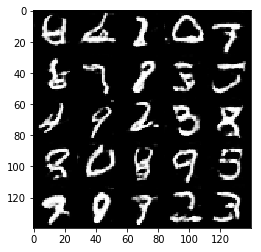

Epoch 2/2... Discriminator Loss: 0.8284 Generator Loss: 1.1279
Epoch 2/2... Discriminator Loss: 0.6769 Generator Loss: 1.6159
Epoch 2/2... Discriminator Loss: 0.6220 Generator Loss: 1.6309
Epoch 2/2... Discriminator Loss: 0.7627 Generator Loss: 1.3033
Epoch 2/2... Discriminator Loss: 0.9448 Generator Loss: 1.9771
Epoch 2/2... Discriminator Loss: 0.7926 Generator Loss: 1.3661
Epoch 2/2... Discriminator Loss: 0.8508 Generator Loss: 1.8509
Epoch 2/2... Discriminator Loss: 0.8593 Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 0.8922 Generator Loss: 1.0509
Epoch 2/2... Discriminator Loss: 0.7508 Generator Loss: 1.3118


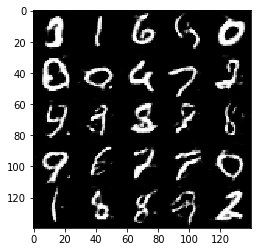

Epoch 2/2... Discriminator Loss: 0.5946 Generator Loss: 1.8052
Epoch 2/2... Discriminator Loss: 0.7273 Generator Loss: 1.3340
Epoch 2/2... Discriminator Loss: 0.7881 Generator Loss: 1.2754
Epoch 2/2... Discriminator Loss: 1.0203 Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 0.6549 Generator Loss: 1.6495
Epoch 2/2... Discriminator Loss: 0.6653 Generator Loss: 1.6923
Epoch 2/2... Discriminator Loss: 0.6503 Generator Loss: 1.7513
Epoch 2/2... Discriminator Loss: 0.6239 Generator Loss: 2.0722
Epoch 2/2... Discriminator Loss: 0.8965 Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 0.7402 Generator Loss: 1.2906


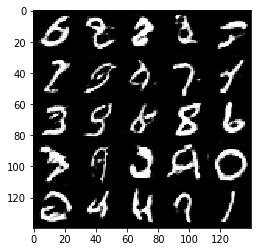

Epoch 2/2... Discriminator Loss: 0.7735 Generator Loss: 1.2396
Epoch 2/2... Discriminator Loss: 0.6807 Generator Loss: 1.5096
Epoch 2/2... Discriminator Loss: 0.7650 Generator Loss: 1.1680
Epoch 2/2... Discriminator Loss: 1.0747 Generator Loss: 2.4704
Epoch 2/2... Discriminator Loss: 0.7373 Generator Loss: 1.3094
Epoch 2/2... Discriminator Loss: 0.7926 Generator Loss: 1.2961
Epoch 2/2... Discriminator Loss: 0.6939 Generator Loss: 1.7012
Epoch 2/2... Discriminator Loss: 0.9713 Generator Loss: 0.8975
Epoch 2/2... Discriminator Loss: 0.8811 Generator Loss: 2.9320
Epoch 2/2... Discriminator Loss: 0.6793 Generator Loss: 2.3237


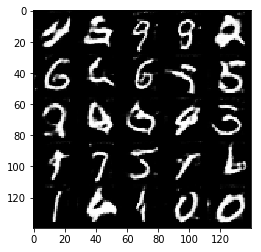

Epoch 2/2... Discriminator Loss: 1.0867 Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 0.9103 Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 0.6950 Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 0.8015 Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 0.6195 Generator Loss: 2.0069
Epoch 2/2... Discriminator Loss: 0.8100 Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.6277 Generator Loss: 1.6651
Epoch 2/2... Discriminator Loss: 0.7336 Generator Loss: 1.6197
Epoch 2/2... Discriminator Loss: 0.6221 Generator Loss: 1.6721
Epoch 2/2... Discriminator Loss: 0.6405 Generator Loss: 2.2018


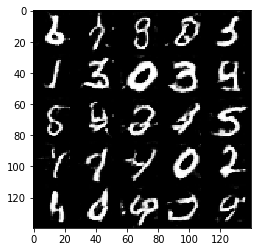

Epoch 2/2... Discriminator Loss: 0.6841 Generator Loss: 1.4118
Epoch 2/2... Discriminator Loss: 0.7908 Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 0.5326 Generator Loss: 2.0755
Epoch 2/2... Discriminator Loss: 0.9286 Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 0.8378 Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 0.8328 Generator Loss: 1.2294
Epoch 2/2... Discriminator Loss: 1.1710 Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 0.6946 Generator Loss: 1.3703
Epoch 2/2... Discriminator Loss: 1.1854 Generator Loss: 0.9241
Epoch 2/2... Discriminator Loss: 1.1860 Generator Loss: 3.1123


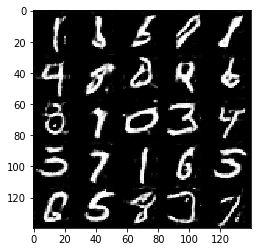

Epoch 2/2... Discriminator Loss: 0.9094 Generator Loss: 1.1074
Epoch 2/2... Discriminator Loss: 0.7939 Generator Loss: 1.2009
Epoch 2/2... Discriminator Loss: 0.7071 Generator Loss: 1.3559
Epoch 2/2... Discriminator Loss: 0.9975 Generator Loss: 1.2022
Epoch 2/2... Discriminator Loss: 0.8157 Generator Loss: 1.2730
Epoch 2/2... Discriminator Loss: 0.6914 Generator Loss: 2.3681
Epoch 2/2... Discriminator Loss: 1.0502 Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 0.8867 Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 0.9876 Generator Loss: 0.8868
Epoch 2/2... Discriminator Loss: 0.7893 Generator Loss: 1.1519


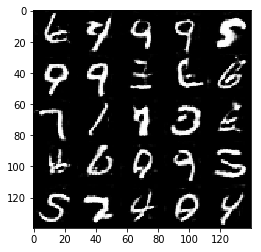

Epoch 2/2... Discriminator Loss: 0.7369 Generator Loss: 1.3365
Epoch 2/2... Discriminator Loss: 0.6531 Generator Loss: 1.6288
Epoch 2/2... Discriminator Loss: 0.6275 Generator Loss: 1.5900
Epoch 2/2... Discriminator Loss: 0.5987 Generator Loss: 1.6945
Epoch 2/2... Discriminator Loss: 0.5994 Generator Loss: 2.0678


In [130]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.15


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8325 Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 0.9046 Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 1.0409 Generator Loss: 4.3564
Epoch 1/1... Discriminator Loss: 0.9194 Generator Loss: 2.0540
Epoch 1/1... Discriminator Loss: 1.1327 Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.6127 Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 0.8498 Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 0.9867 Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 1.0815 Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.1631 Generator Loss: 2.0026


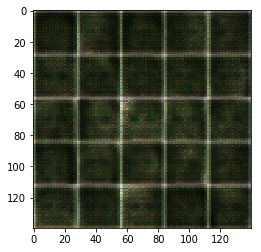

Epoch 1/1... Discriminator Loss: 1.0068 Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 0.8701 Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 0.9457 Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 0.9579 Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 2.1085 Generator Loss: 4.1524
Epoch 1/1... Discriminator Loss: 1.1214 Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.1169 Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 0.8873 Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.0160 Generator Loss: 1.8964
Epoch 1/1... Discriminator Loss: 1.1990 Generator Loss: 0.8837


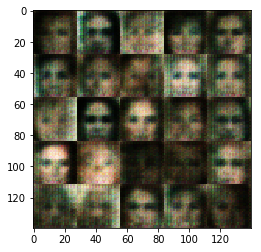

Epoch 1/1... Discriminator Loss: 1.2198 Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2989 Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4615 Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 0.9566 Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 0.9550 Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.4158 Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.1388 Generator Loss: 2.6714
Epoch 1/1... Discriminator Loss: 0.9359 Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 0.8381 Generator Loss: 1.8500
Epoch 1/1... Discriminator Loss: 0.6779 Generator Loss: 1.8559


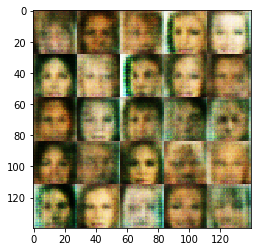

Epoch 1/1... Discriminator Loss: 1.0801 Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 0.8641 Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 0.9844 Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 0.8035 Generator Loss: 1.9038
Epoch 1/1... Discriminator Loss: 0.8859 Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 0.8998 Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.0647 Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 1.1472 Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.2744 Generator Loss: 1.4188
Epoch 1/1... Discriminator Loss: 1.3108 Generator Loss: 0.8728


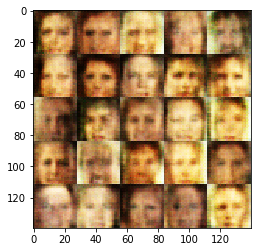

Epoch 1/1... Discriminator Loss: 1.1915 Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 0.9306 Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 0.9884 Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.8903 Generator Loss: 0.2967
Epoch 1/1... Discriminator Loss: 1.1701 Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.9726 Generator Loss: 2.9236
Epoch 1/1... Discriminator Loss: 1.3993 Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.1857 Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.1763 Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.2591 Generator Loss: 0.6595


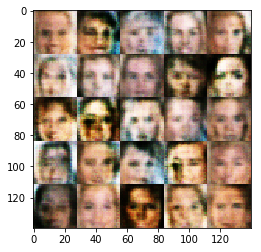

Epoch 1/1... Discriminator Loss: 1.6154 Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.2173 Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.1029 Generator Loss: 2.0570
Epoch 1/1... Discriminator Loss: 1.0047 Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.2381 Generator Loss: 1.5340
Epoch 1/1... Discriminator Loss: 1.2222 Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.1067 Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.2655 Generator Loss: 2.1681
Epoch 1/1... Discriminator Loss: 1.1312 Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.0757 Generator Loss: 0.9900


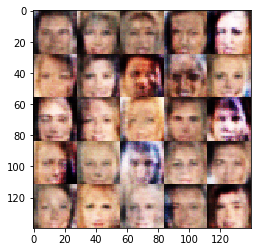

Epoch 1/1... Discriminator Loss: 1.3644 Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.5286 Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.2809 Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.1840 Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.2747 Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.4264 Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3148 Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.1955 Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 1.2995 Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.0919 Generator Loss: 1.0994


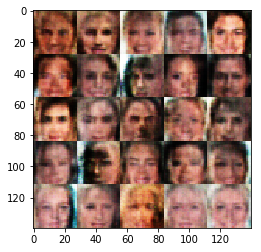

Epoch 1/1... Discriminator Loss: 1.2059 Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.1776 Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.2374 Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 1.0309 Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.1259 Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.0927 Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.1774 Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.2066 Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.1429 Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 2.2316 Generator Loss: 0.1892


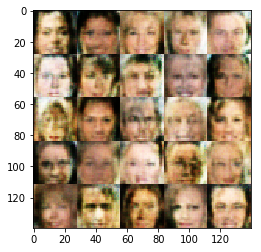

Epoch 1/1... Discriminator Loss: 1.2439 Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4949 Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 1.0519 Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.0824 Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 0.8036 Generator Loss: 1.7574
Epoch 1/1... Discriminator Loss: 0.9766 Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 1.2747 Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.5043 Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.1496 Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 0.8692 Generator Loss: 1.1718


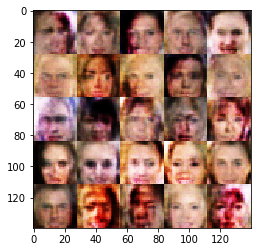

Epoch 1/1... Discriminator Loss: 1.2257 Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.0891 Generator Loss: 2.0675
Epoch 1/1... Discriminator Loss: 0.9663 Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 1.0861 Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 1.1267 Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2522 Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.1188 Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.3334 Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 0.9870 Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.2520 Generator Loss: 0.8091


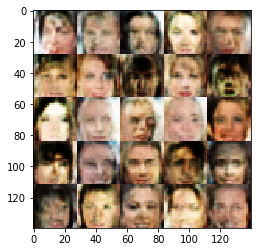

Epoch 1/1... Discriminator Loss: 0.9732 Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 0.9865 Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.8745 Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 1.1523 Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.2539 Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 0.8419 Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.7038 Generator Loss: 2.7553
Epoch 1/1... Discriminator Loss: 0.9871 Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.5456 Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 0.8812 Generator Loss: 2.1629


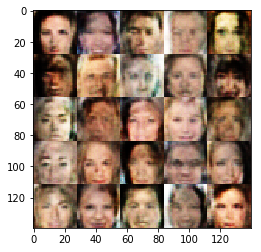

Epoch 1/1... Discriminator Loss: 1.3746 Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.9593 Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 0.8510 Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 1.1717 Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 0.8310 Generator Loss: 1.7247
Epoch 1/1... Discriminator Loss: 1.0735 Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.2938 Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.6569 Generator Loss: 2.4224
Epoch 1/1... Discriminator Loss: 1.1448 Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.1493 Generator Loss: 1.9719


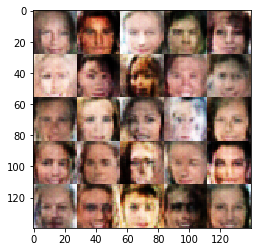

Epoch 1/1... Discriminator Loss: 1.1378 Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.1277 Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2175 Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 0.9127 Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 0.9562 Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.0797 Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 0.8191 Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.9642 Generator Loss: 1.6125
Epoch 1/1... Discriminator Loss: 0.9261 Generator Loss: 1.8456
Epoch 1/1... Discriminator Loss: 1.1837 Generator Loss: 1.1912


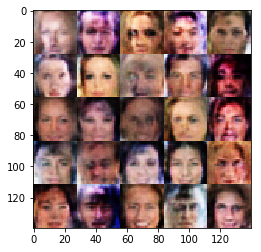

Epoch 1/1... Discriminator Loss: 0.9296 Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 1.3509 Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.2737 Generator Loss: 2.4600
Epoch 1/1... Discriminator Loss: 1.3403 Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.1763 Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 0.9956 Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.0630 Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.0339 Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 0.8541 Generator Loss: 1.3923
Epoch 1/1... Discriminator Loss: 1.0589 Generator Loss: 2.4172


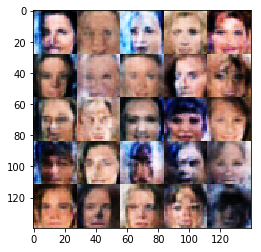

Epoch 1/1... Discriminator Loss: 1.0524 Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.1216 Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.0394 Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.0850 Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.8223 Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 1.0810 Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.0247 Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2291 Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.1437 Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.0151 Generator Loss: 1.1529


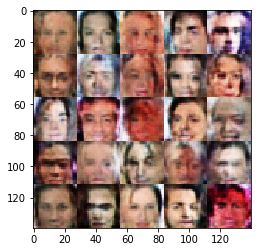

Epoch 1/1... Discriminator Loss: 0.7934 Generator Loss: 1.9297
Epoch 1/1... Discriminator Loss: 1.1184 Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 0.9873 Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 0.9429 Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 1.1958 Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 0.9966 Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.2594 Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 0.9421 Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.9952 Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 0.9988 Generator Loss: 1.1611


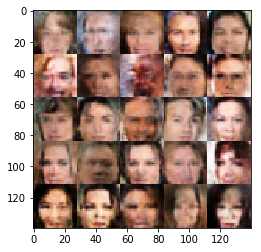

Epoch 1/1... Discriminator Loss: 1.0347 Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.2904 Generator Loss: 2.7065
Epoch 1/1... Discriminator Loss: 1.2451 Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.9033 Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.1015 Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.1085 Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.8995 Generator Loss: 1.8292
Epoch 1/1... Discriminator Loss: 1.1901 Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3331 Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.3027 Generator Loss: 1.1067


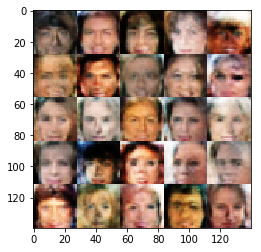

Epoch 1/1... Discriminator Loss: 1.2957 Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 0.9731 Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 0.7956 Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 0.7727 Generator Loss: 1.7266
Epoch 1/1... Discriminator Loss: 0.9983 Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.0263 Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 1.2818 Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.3684 Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.4108 Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.0714 Generator Loss: 2.2059


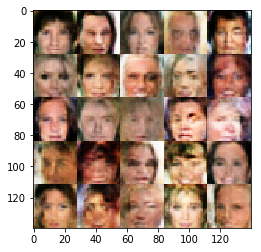

Epoch 1/1... Discriminator Loss: 1.2578 Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.0151 Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.0127 Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 0.9642 Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.0171 Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.2500 Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.0061 Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.1443 Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 0.9209 Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.0881 Generator Loss: 0.7145


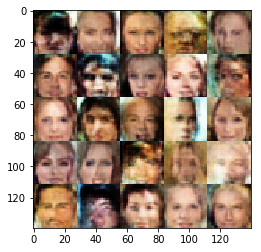

Epoch 1/1... Discriminator Loss: 1.2158 Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 0.8685 Generator Loss: 1.9363
Epoch 1/1... Discriminator Loss: 1.1932 Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 0.9851 Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.9103 Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 1.1638 Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.2279 Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.4981 Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 1.1813 Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 0.9961 Generator Loss: 1.0297


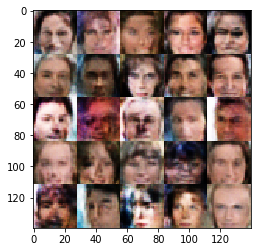

Epoch 1/1... Discriminator Loss: 1.2521 Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.1062 Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 1.0344 Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.1488 Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.1310 Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.1301 Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.4286 Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 0.6382 Generator Loss: 2.1119
Epoch 1/1... Discriminator Loss: 0.7281 Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 1.2822 Generator Loss: 1.7170


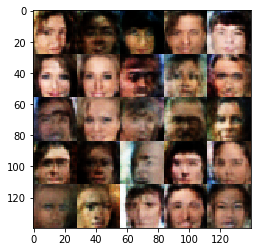

Epoch 1/1... Discriminator Loss: 1.0750 Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.9872 Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 1.4066 Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 0.8846 Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 1.1166 Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.0563 Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 0.7619 Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 1.2232 Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.2475 Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.0986 Generator Loss: 1.3388


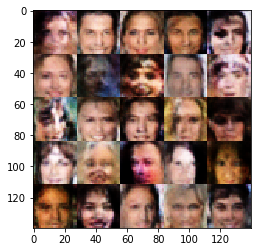

Epoch 1/1... Discriminator Loss: 0.9594 Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 1.1007 Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 0.9398 Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.8695 Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 0.9196 Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.2464 Generator Loss: 1.7473
Epoch 1/1... Discriminator Loss: 1.0434 Generator Loss: 1.6880
Epoch 1/1... Discriminator Loss: 0.9794 Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.0855 Generator Loss: 1.4793
Epoch 1/1... Discriminator Loss: 1.3991 Generator Loss: 0.5271


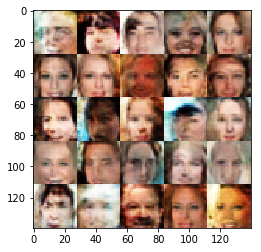

Epoch 1/1... Discriminator Loss: 0.9968 Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.6472 Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.3703 Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 0.9705 Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.0401 Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.1359 Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 0.9759 Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 0.8592 Generator Loss: 1.8951
Epoch 1/1... Discriminator Loss: 1.0058 Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.0965 Generator Loss: 1.3157


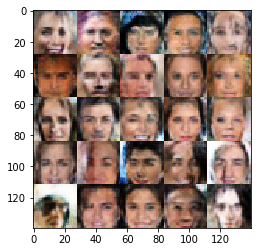

Epoch 1/1... Discriminator Loss: 1.3376 Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 0.8288 Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.9699 Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.0564 Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.9655 Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.4047 Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.1999 Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3089 Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 0.8608 Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.6439 Generator Loss: 1.7785


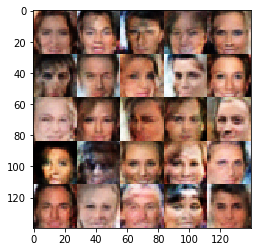

Epoch 1/1... Discriminator Loss: 1.1819 Generator Loss: 1.6532
Epoch 1/1... Discriminator Loss: 1.1098 Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.1942 Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.0773 Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.8080 Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 1.0685 Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.4236 Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 0.9287 Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 0.8665 Generator Loss: 1.1806


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.